In [1]:
movie_data = sc.textFile("ml-100k/u.item")
print movie_data.first()
num_movies = movie_data.count()
print "Movies: %d" % num_movies

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


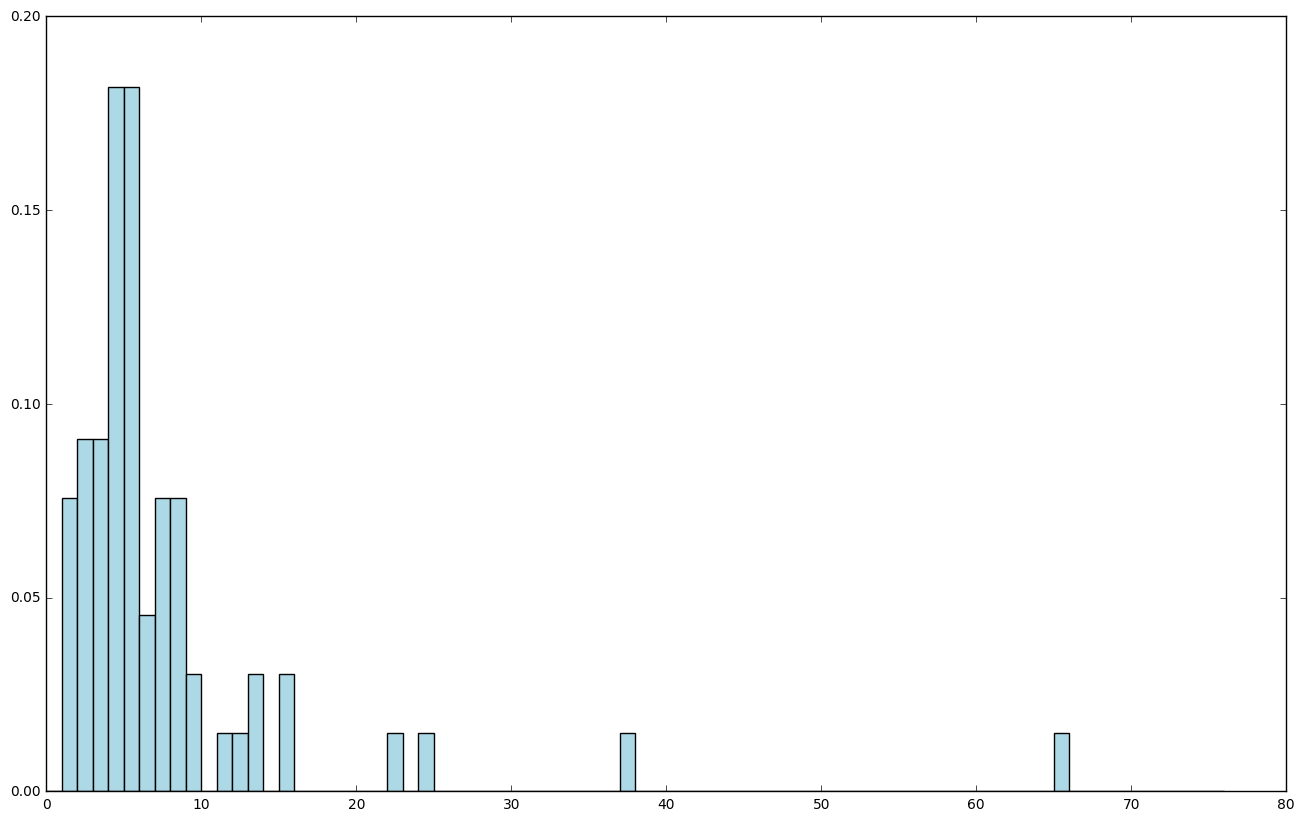

In [2]:
import matplotlib.pyplot as plt

def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900 #There is a 'bad' data point with blank year, which we set to 1900 and will filter out later

movie_fields = movie_data.map(lambda lines: lines.split("|"))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
years_filtered = years.filter(lambda x: x != 1900)

movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
values = movie_ages.values()
bins = movie_ages.keys()
plt.hist(values, bins=bins, color='lightblue', normed=True)
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.show()

In [3]:
import numpy as np

years_pre_processed = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x)).collect()
years_pre_processed_array = np.array(years_pre_processed)

mean_year = np.mean(years_pre_processed_array[years_pre_processed_array!=1900])
median_year = np.median(years_pre_processed_array[years_pre_processed_array!=1900])

index_bad_data = np.where(years_pre_processed_array==1900)[0][0]
years_pre_processed_array[index_bad_data] = median_year

print "Mean year of release: %d" % mean_year
print "Median year of release: %d" % median_year

print "Index of '1900' after assigning median: %s" % np.where(years_pre_processed==1900)[0]

Mean year of release: 1989
Median year of release: 1995
Index of '1900' after assigning median: []


In [4]:
import re

def extract_title(raw):
    grps = re.search("\((\w+)\)", raw)
    if grps:
        return raw[:grps.start()].strip()
    else:
        return raw
    
raw_titles = movie_fields.map(lambda fields: fields[1])

for raw_title in raw_titles.take(5):
    print extract_title(raw_title)

Toy Story
GoldenEye
Four Rooms
Get Shorty
Copycat


In [5]:
movie_titles = raw_titles.map(lambda m: extract_title(m))
title_terms = movie_titles.map(lambda t: t.split(" "))
print title_terms.take(5)

[[u'Toy', u'Story'], [u'GoldenEye'], [u'Four', u'Rooms'], [u'Get', u'Shorty'], [u'Copycat']]


In [6]:
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()
idx = 0
all_terms_dict = {}
for term in all_terms:
    all_terms_dict[term] = idx
    idx += 1
    
print "Total number of terms: %d" % len(all_terms_dict)
print "Index of term 'Dead': %d" % all_terms_dict['Dead']
print "Index of term 'Rooms': %d" % all_terms_dict['Rooms']

Total number of terms: 2645
Index of term 'Dead': 147
Index of term 'Rooms': 1963


In [8]:
all_terms_dict2 = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()
print "Index of term 'Dead': %d" % all_terms_dict2['Dead']
print "Index of term 'Rooms': %d" % all_terms_dict2['Rooms']

Index of term 'Dead': 147
Index of term 'Rooms': 1963


In [11]:
from scipy import sparse as sp

def create_vector(terms, term_dict):
    num_terms = len(term_dict)
    x = sp.csc_matrix((1, num_terms))
    for t in term:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x

all_terms_bcast = sc.broadcast(all_terms_dict)
term_vectors = title_terms.map(lambda terms: create_vector(terms, all_terms_bcast.value))
term_vectors.take(5)

[<1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>]

In [13]:
np.random.seed(42)
x = np.random.randn(10)
norm_x_2 = np.linalg.norm(x)
normalized_x = x / norm_x_2
print "x:\n%s" % x
print "2-Norm of x: %2.4f" % norm_x_2
print "Normalized x:\n%s" % normalized_x
print "2-Norm of normalized_x: %2.4f" % np.linalg.norm(normalized_x)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x: 1.0000


In [15]:
from pyspark.mllib.feature import Normalizer

normalizer = Normalizer()
vector = sc.parallelize([x])

normalized_x_mllib = normalizer.transform(vector).first().toArray()

print "x:\n%s" % x
print "2-Norm of x: %2.4f" % norm_x_2
print "Normalized x MLlib:\n%s" % normalized_x_mllib
print "2-Norm of normalized_x_mllib: %2.4f" % np.linalg.norm(normalized_x_mllib)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x MLlib:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x_mllib: 1.0000
